In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
def positional_encoding(positions, d):
    angle_rads = np.arange(positions)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d)[np.newaxis, :]//2)) / np.float32(d))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

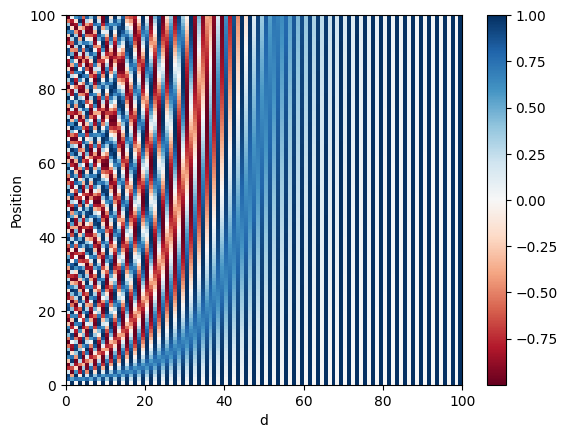

In [4]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 64
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, EMBEDDING_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
pos = 34
tf.norm(pos_encoding[0,pos,:])

<tf.Tensor: shape=(), dtype=float32, numpy=7.071068>

In [6]:
pos = 70
k = 2
print(tf.norm(pos_encoding[0,pos,:] - pos_encoding[0,pos + k,:]))

tf.Tensor(3.2668781, shape=(), dtype=float32)


### Comparing positional encodings

#### Correlation

A successful positional encoder will produce a perfectly symmetric matrix in which maximum values are located at the main diagonal - vectors in similar positions should have the highest correlation. Following the same logic, the correlation values should get smaller as they move away from the main diagonal.

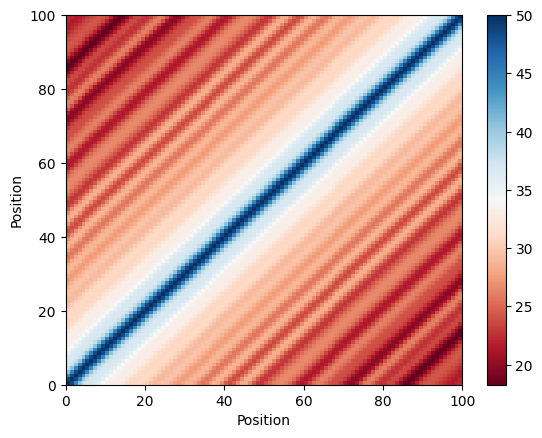

In [8]:
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Euclidean distance

(100, 100)


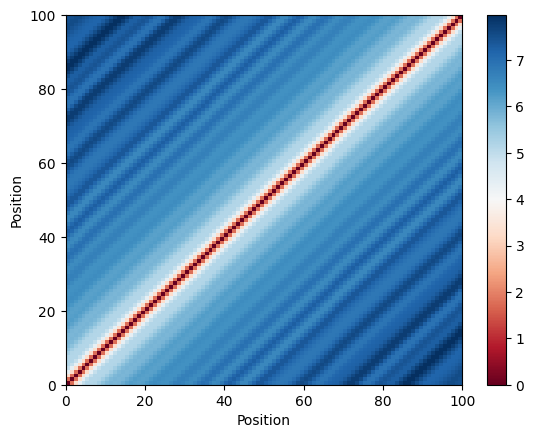

In [10]:
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
print(eu.shape)
for a in range(MAX_SEQUENCE_LENGTH):
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
        eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0, b]))
        eu[b, a] = eu[a, b]
        
plt.pcolormesh(eu, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Semantic embedding

In [13]:
embeddings_index = {}
GLOVE_DIR = 'glove'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print('d_model:', embeddings_index['hi'].shape)

Found 400000 word vectors.
d_model: (100,)


In [14]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog woman football king red wolf']

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

print(data.shape)

print(data)

Found 11 unique tokens.
(2, 100)
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


In [16]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(12, 100)


In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

In [18]:
embedding = embedding_layer(data)
print(embedding.shape)

(2, 100, 100)


In [19]:
from sklearn.decomposition import PCA
def plot_words(embedding, sequences, sentence):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence,0:len(sequences[sentence]),:])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())
    for i, index in enumerate(sequences[sentence]):
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))

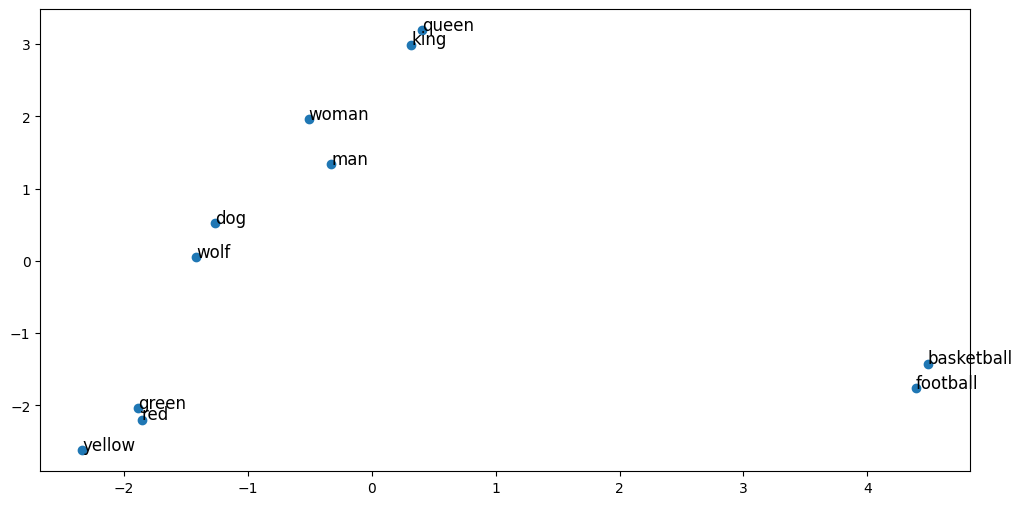

In [20]:
plot_words(embedding, sequences, 0)

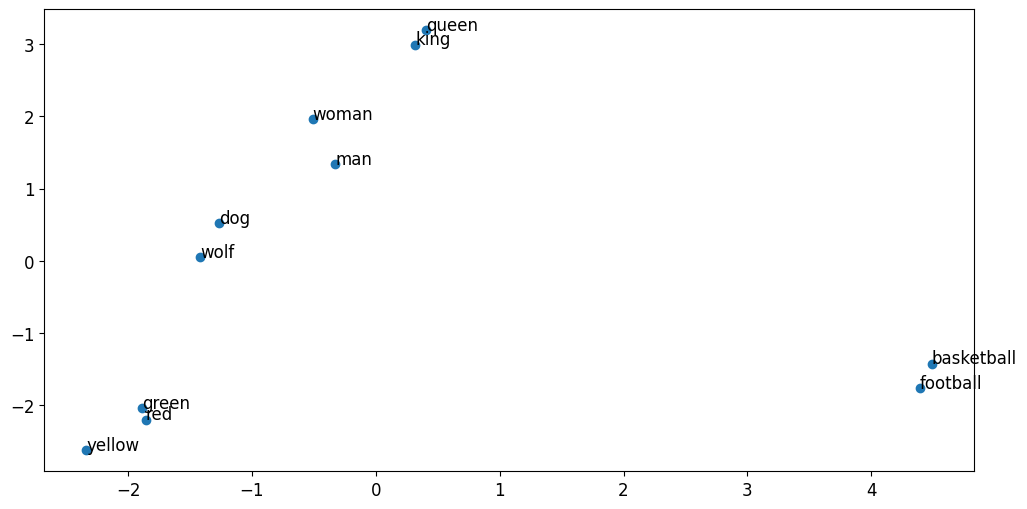

In [21]:
plot_words(embedding, sequences, 1)

## Semantic and positional embedding

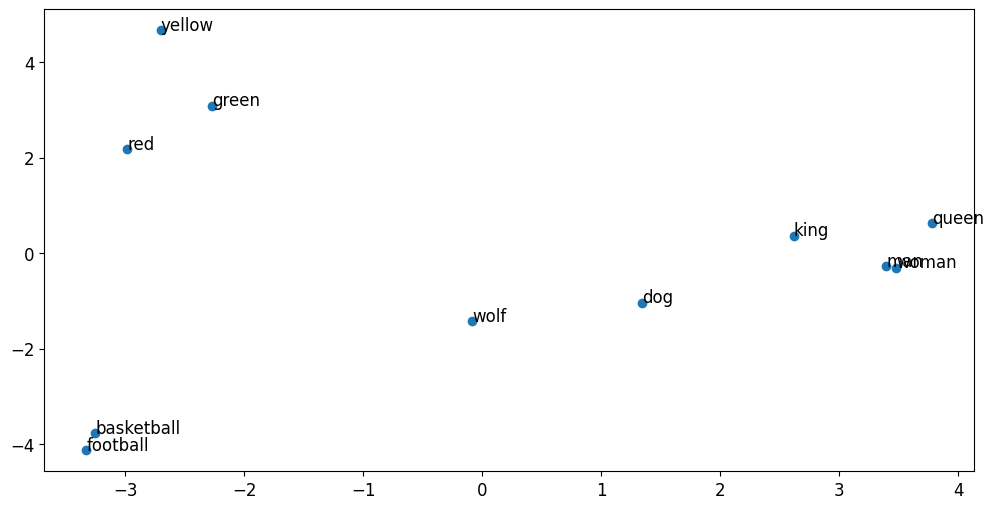

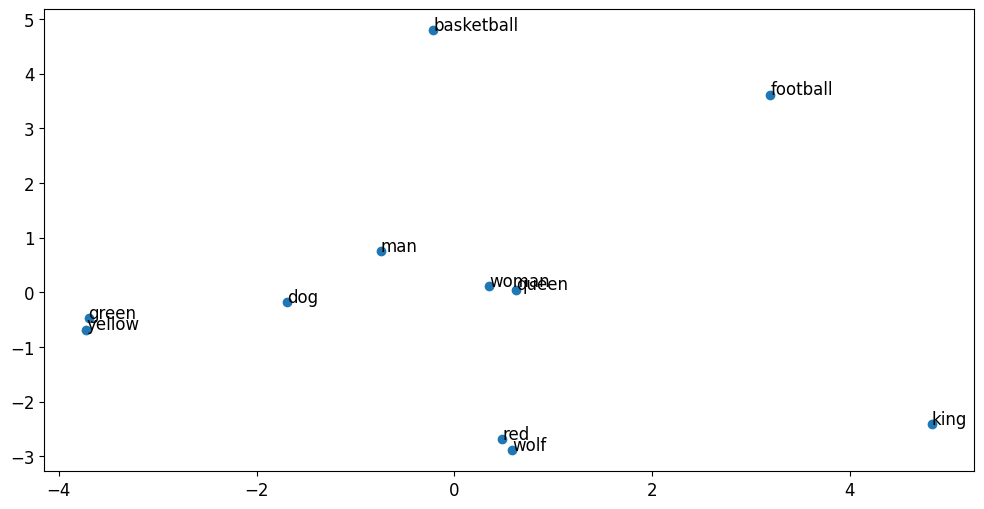

In [23]:
embedding2 = embedding * 1.0 + pos_encoding[:,:,:] * 1.0

plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

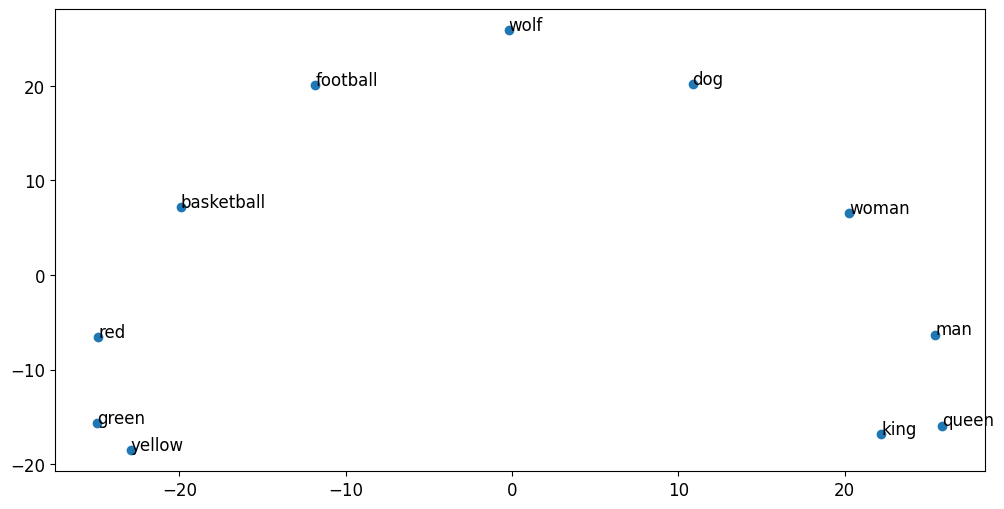

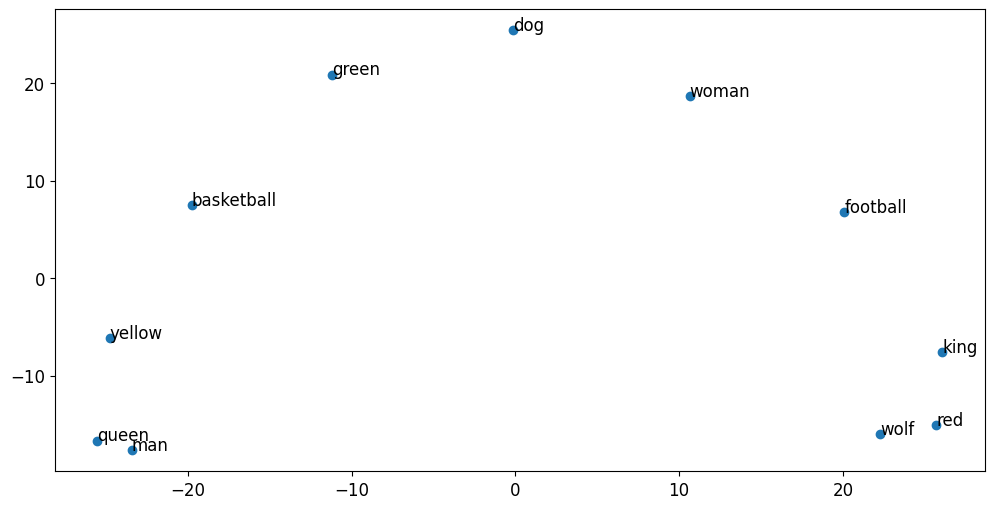

In [24]:
W1 = 1
W2 = 10
embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2
plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)